In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset

import numpy as np
import matplotlib.pyplot as plt

from models.rectifier import FuzzyRectifier

In [2]:
plt.rc("figure", dpi=250, titlesize=6)
plt.rc("legend", fontsize=6)

In [3]:
torch.autograd.set_grad_enabled(False)

In [4]:
def make_blobs(samples_per_blob: int = 100, *, centers: int = 8, radius: float = 10.0, std: float = 1.0, shuffle=True):
    """ Make 2D gaussian blobs distributed equally on a circle about the origin """
    phis = np.linspace(0, 2 * np.pi, num=centers + 1)[:-1]
    means = np.empty((centers, 2))
    means[:, 0] = radius * np.cos(phis)
    means[:, 1] = radius * np.sin(phis)

    samples = np.random.normal(means, std, size=(samples_per_blob, centers, 2))
    labels = np.resize(np.arange(centers), (samples_per_blob, centers))

    # flatten
    samples = samples.reshape(samples_per_blob * centers, 2)
    labels = labels.reshape(-1)

    if shuffle:
        sort = np.random.permutation(len(samples))
        samples = samples[sort, ...]
        labels = labels[sort, ...]

    return samples, labels

In [5]:
train_data, _ = make_blobs(4096, centers=4)
val_data, _ = make_blobs(1024, centers=4)

In [6]:
train_data = torch.from_numpy(train_data.astype(np.float32))
train_means = torch.zeros_like(train_data)
train_stds = torch.ones_like(train_data)

val_data = torch.from_numpy(val_data.astype(np.float32))
val_means = torch.zeros_like(val_data)
val_stds = torch.ones_like(val_data)

In [7]:
train_dataset = TensorDataset(train_data, train_means, train_stds)
val_dataset = TensorDataset(val_data, val_means, val_stds)

In [8]:
hparams = dict(
    inputs=2,
    time_samples=4,
    batch_size=512,
    widths=[128, 256, 256, 128],
    max_epochs=10,
    gradient_clip=1.0,
)

In [9]:
model = FuzzyRectifier(train_dataset, val_dataset, **hparams)

In [10]:
trainer = model.configure_trainer()

with torch.autograd.enable_grad():
    model.train()
    trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 132 K 
---------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0.530     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/lars/code/python/point-clouds/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [11]:
noise = model.distribution.sample((128,))
samples, _ = model.inverse(noise)

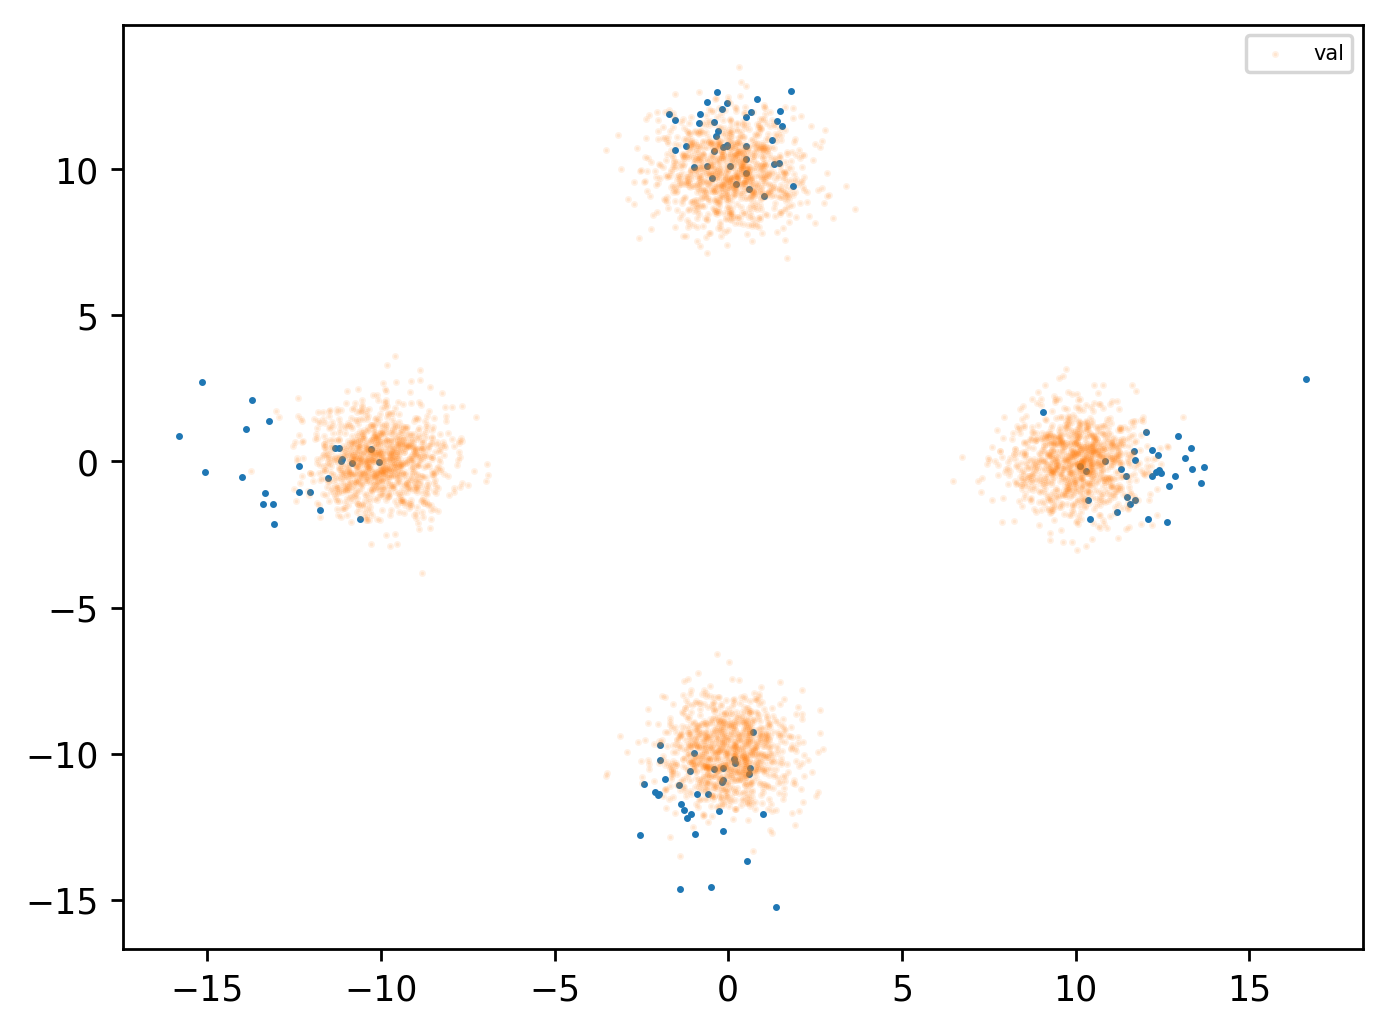

In [12]:
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.scatter(val_data[:, 0], val_data[:, 1], s=1, alpha=0.1, label="val")
plt.legend()

In [13]:
model.rectify()

IndexError: index 123686656 is out of bounds for dimension 0 with size 16384